## Preprocessing the data

In [3]:
import pandas as pd
import holidays
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from statsmodels.tsa.seasonal import STL
from darts import TimeSeries
from darts.metrics import mape, rmse, mae


# Create a DataFrame from Load source
load2023 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2023.csv", delimiter=",")
load2024 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2024.csv", delimiter=",")
load_df = pd.concat([load2023, load2024], ignore_index=True)

# Read temperature data (downlaoded from SMHI)
weather_data = pd.read_csv("Temperature Data/smhi-opendata_1_98230_202301_202412.csv", delimiter=";", skiprows=9)

# Process load data by changing column name
load_df['Time (UTC)'] = load_df['Time (UTC)'].str.split(' - ').str[0]
load_df = load_df.rename(columns={'Time (UTC)': 'completetime', 'Actual Total Load [MW] - BZN|SE3': 'Load'})
load_df['datetime'] = pd.to_datetime(load_df['completetime'], format='%d.%m.%Y %H:%M')
load_df = load_df.drop(['completetime'], axis=1)

# Create datetime in weather_data
date_col = 'Datum'  
time_col = 'Tid (UTC)'  

# Create datetime column in weather_data by combining date and time
weather_data['datetime'] = pd.to_datetime(
    weather_data[date_col].astype(str) + ' ' + weather_data[time_col].astype(str)
)

# Create a temporary dataframe with just datetime and temperature
temp_df = weather_data[['datetime', 'Lufttemperatur']].copy()
temp_df.rename(columns={'Lufttemperatur': 'Temperature'}, inplace=True)


# Remove any duplicates in temperature data (checking by datetime)
if temp_df['datetime'].duplicated().any():
    print(f"Found {temp_df['datetime'].duplicated().sum()} duplicate timestamps in temperature data Stockholm")
    temp_df = temp_df.drop_duplicates(subset=['datetime'])

# Merge the dataframes based on datetime
print(f"Load data shape before merge: {load_df.shape}")
load_df = load_df.merge(temp_df, on='datetime', how='left')
print(f"Load data shape after merge: {load_df.shape}")

# Check for missing temperature values and identify where they are
missing_temp = load_df['Temperature'].isna().sum()
print(f"\nMissing temperature values after merge: {missing_temp}")

# Check the temprature missing data and doing interpolation
if missing_temp > 0:
    # Find rows with missing temperature values
    missing_rows = load_df[load_df['Temperature'].isna()]
    
    # Display information about the missing data
    print("\nRows with missing temperature values:")
    print(f"Total missing values: {len(missing_rows)}")
    
    # Show the first few rows with missing values
    print("\nFirst 10 rows with missing temperature values:")
    print(missing_rows[['datetime', 'Load']].head(10))
    
    # Show the distribution of missing values by month and hour
    print("\nMissing values by month:")
    print(missing_rows['datetime'].dt.month.value_counts().sort_index())
    
    print("\nMissing values by hour of day:")
    print(missing_rows['datetime'].dt.hour.value_counts().sort_index())
    
    # Check if missing values are consecutive
    missing_rows_sorted = missing_rows.sort_values('datetime')
    time_diff = missing_rows_sorted['datetime'].diff()
    
    print("\nTime differences between consecutive missing values (first 10):")
    print(time_diff.head(10))
    
    # Identify gaps in temperature data
    common_diff = time_diff.mode()[0]
    print(f"Most common time difference between missing values: {common_diff}")
    
    # Set datetime as index for time-based interpolation
    load_df_temp = load_df.set_index('datetime')
    
    # Perform interpolation
    load_df_temp['Temperature'] = load_df_temp['Temperature'].interpolate(method='time')
    
    # Handle any remaining missing values
    load_df_temp['Temperature'] = load_df_temp['Temperature'].fillna(method='ffill').fillna(method='bfill')
    
    # Reset index
    load_df = load_df_temp.reset_index()
    
    print(f"\nRemaining missing values after interpolation: {load_df['Temperature'].isna().sum()}")

# Adding day type (Month, Week and hour of the day)
load_df['Month'] = load_df['datetime'].dt.month
load_df['Day_of_week'] = load_df['datetime'].dt.dayofweek
load_df['Hour_of_day'] = load_df['datetime'].dt.hour

# change column name
load_df['entso-e_forecast']=load_df['Day-ahead Total Load Forecast [MW] - BZN|SE3']

# Adding Holidays 
Sweden_holidays = holidays.CountryHoliday('SE')
load_df['Holidays'] = [int((date in Sweden_holidays) and date.weekday() != 6) for date in load_df.datetime]

# Create Daylight Saving Column covariates
# Define Sweden timezone
sweden_tz = pytz.timezone('Europe/Stockholm')

def is_dst_sweden(naive_dt):
    try:
        # First, assume the naive datetime is in UTC
        utc_dt = pd.Timestamp(naive_dt).tz_localize('UTC')
        # Then convert UTC time to Sweden time
        sweden_time = utc_dt.astimezone(sweden_tz)
        # Return 1 if DST is active, 0 if not
        return int(sweden_time.dst() != pd.Timedelta(0))
    except Exception as e:
        print(f"Error processing {naive_dt}: {e}")
        return None

# Apply the function to get DST status (1 or 0)
load_df['DST'] = load_df['datetime'].apply(is_dst_sweden)

# Reorder columns
load_df = load_df[['datetime', 'entso-e_forecast','Load', 'Temperature', 'Month','Day_of_week', 'Hour_of_day', 'Holidays','DST']]

# Display a sample of the final dataframe
print("\nFinal dataframe sample:")
print(load_df.head())

# Convert the panda data frame into DART dataseries
Load = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Load"]
)

Temp = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Temperature"]
)

Holidays = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Holidays"]
)

load_df

Load data shape before merge: (17544, 3)
Load data shape after merge: (17544, 4)

Missing temperature values after merge: 9

Rows with missing temperature values:
Total missing values: 9

First 10 rows with missing temperature values:
                 datetime   Load
6800  2023-10-11 08:00:00   9888
6801  2023-10-11 09:00:00   9850
6802  2023-10-11 10:00:00   9679
6803  2023-10-11 11:00:00   9544
6805  2023-10-11 13:00:00   9245
6943  2023-10-17 07:00:00  10537
6944  2023-10-17 08:00:00  10341
14983 2024-09-16 07:00:00   9398
14984 2024-09-16 08:00:00   9359

Missing values by month:
datetime
9     2
10    7
Name: count, dtype: int64

Missing values by hour of day:
datetime
7     2
8     3
9     1
10    1
11    1
13    1
Name: count, dtype: int64

Time differences between consecutive missing values (first 10):
6800                  NaT
6801      0 days 01:00:00
6802      0 days 01:00:00
6803      0 days 01:00:00
6805      0 days 02:00:00
6943      5 days 18:00:00
6944      0 days 01:00

C:\Users\jakfa\AppData\Local\Temp\ipykernel_13584\834141821.py:92: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  load_df_temp['Temperature'] = load_df_temp['Temperature'].fillna(method='ffill').fillna(method='bfill')



Final dataframe sample:
             datetime  entso-e_forecast  Load  Temperature  Month  \
0 2023-01-01 00:00:00              8897  8943          3.6      1   
1 2023-01-01 01:00:00              8836  8929          3.0      1   
2 2023-01-01 02:00:00              8779  8887          2.6      1   
3 2023-01-01 03:00:00              8806  8859          2.4      1   
4 2023-01-01 04:00:00              8958  8880          2.0      1   

   Day_of_week  Hour_of_day  Holidays  DST  
0            6            0         0    0  
1            6            1         0    0  
2            6            2         0    0  
3            6            3         0    0  
4            6            4         0    0  


,datetime,entso-e_forecast,Load,Temperature,Month,Day_of_week,Hour_of_day,Holidays,DST
0,2023-01-01 00:00:00,8897,8943,3.6,1,6,0,0,0
1,2023-01-01 01:00:00,8836,8929,3.0,1,6,1,0,0
2,2023-01-01 02:00:00,8779,8887,2.6,1,6,2,0,0
3,2023-01-01 03:00:00,8806,8859,2.4,1,6,3,0,0
4,2023-01-01 04:00:00,8958,8880,2.0,1,6,4,0,0
...,...,...,...,...,...,...,...,...,...
17539,2024-12-31 19:00:00,10929,11092,-2.1,12,1,19,1,0
17540,2024-12-31 20:00:00,10568,10798,-1.8,12,1,20,1,0
17541,2024-12-31 21:00:00,10272,10531,-3.0,12,1,21,1,0
17542,2024-12-31 22:00:00,9981,10165,-2.7,12,1,22,1,0


### Check Outlier

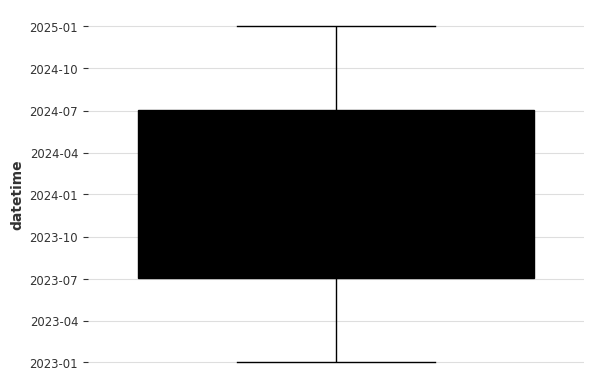

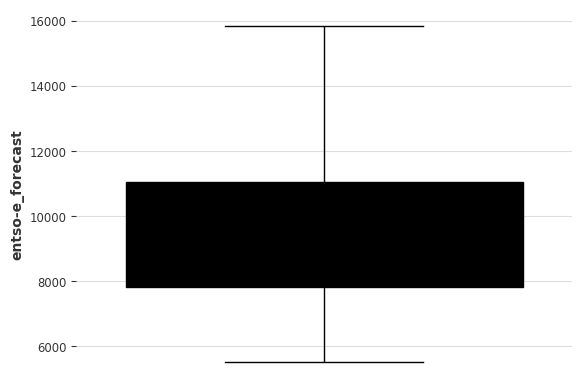

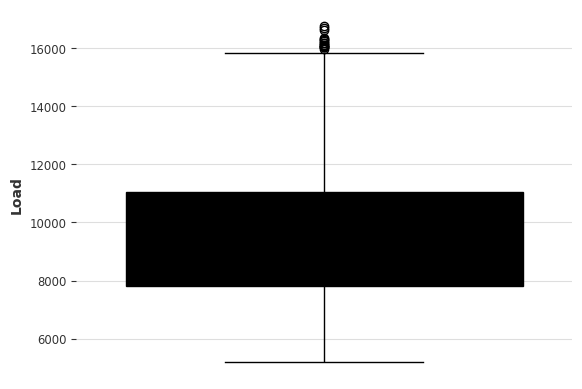

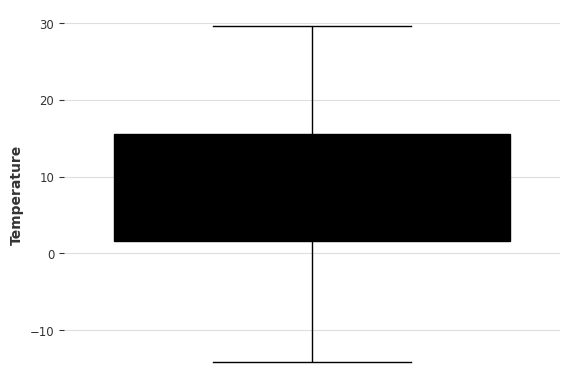

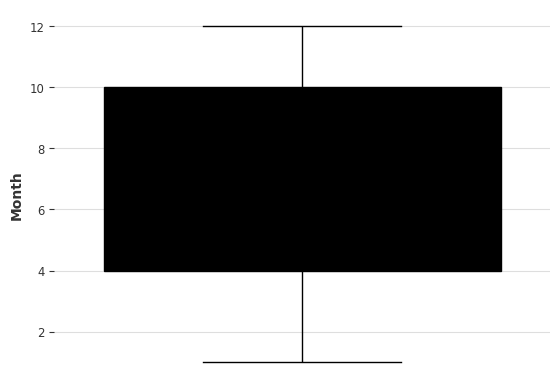

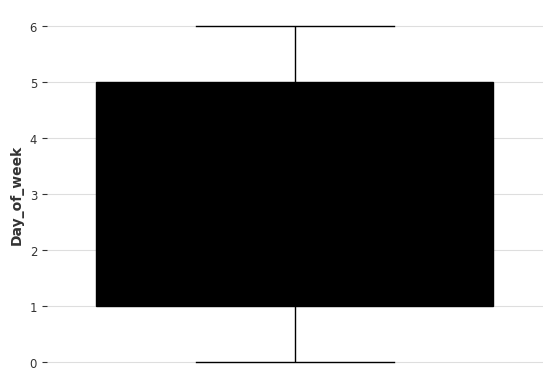

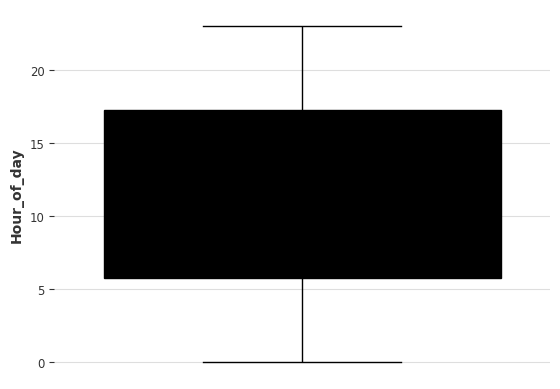

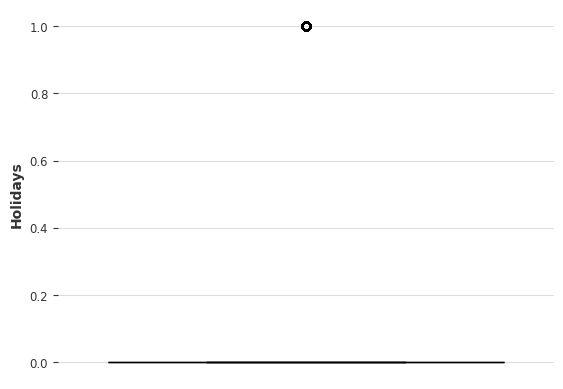

In [4]:
# To find outliers
cols = load_df.columns[0:-1]
for i in cols:
    sns.boxplot(y=load_df[i])
    plt.show()

## Set Training and Test Data

In [ ]:
# Split 80% Load Data for training and 20% for testing
total_samples = len(Load)
split_point = int(total_samples * 0.8)

# Assuming the Load class has an iloc-like method or can take indices
load_train = Load[:split_point]
load_test = Load[split_point:]

## Create Evaluation Function
Show the grap of forecast vs Actual and use MAPE,MAE and RMSE
1. eval_model function (normal) for calculate the error
2. eval_model_transform (for machine learning/RNN since it need transform data scaling (0-1) back to normal MW again) 

In [ ]:
def eval_model(model, past_covariates=None, future_covariates=None, to_retrain=True):
    
    backtest = model.historical_forecasts(series=Load, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=pd.to_datetime('2024-09-01'), 
                                          retrain=to_retrain,
                                          verbose=False, 
                                          forecast_horizon=24)
    
    Load[-len(backtest)-168:].plot()
    backtest.plot(label='Backtest')
    print('Backtest MAPE = {}'.format(mape(Load, backtest)))
    print('Backtest MAE = {}'.format(mae(Load,backtest)))
    print('Backtest RMSE = {}'.format(rmse(Load,backtest)))
    plt.show()

    error = Load[-len(backtest):].to_series() - backtest.to_series()
    error.rolling(49, center=True).mean().plot()
    plt.show()

In [ ]:
def eval_model_transform(model, past_covariates=None, future_covariates=None, to_retrain=True):
    
    backtest = model.historical_forecasts(series=Load_transformed, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=pd.to_datetime('2024-10-30'), 
                                          retrain=to_retrain,
                                          verbose=False, 
                                          forecast_horizon=24)
    
    # Inverse-transform predictions to original scale
    backtest_scaled = transformer.inverse_transform(backtest)

    Load[-len(backtest)-168:].plot()
    backtest_scaled.plot(label='Backtest')
    print('Backtest MAPE = {}'.format(mape(Load, backtest_scaled)))
    print('Backtest MAE = {}'.format(mae(Load, backtest_scaled)))
    print('Backtest RMSE = {}'.format(rmse(Load, backtest_scaled)))
    plt.show()

    error = Load[-len(backtest_scaled):].to_series() - backtest_scaled.to_series()
    error.rolling(49, center=True).mean().plot()
    plt.show()

## Test using Naive seasonal K=24 MODEL

Backtest MAPE = 5.8352201276810955
Backtest MAE = 566.1814113597246
Backtest RMSE = 764.5653320599566


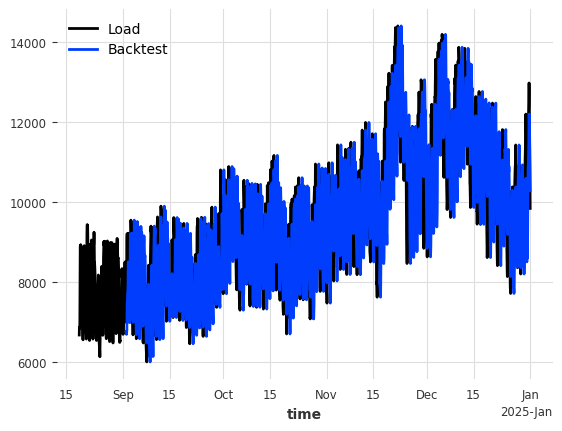

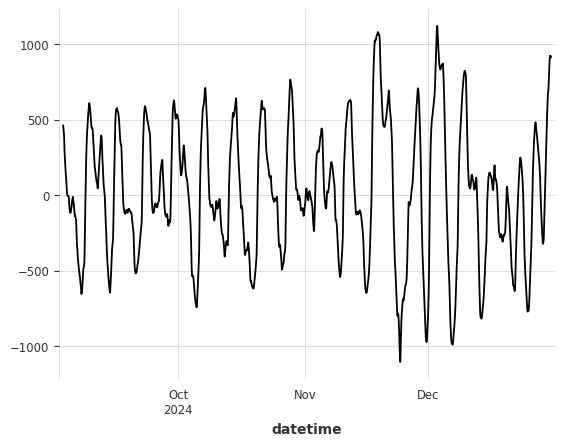

In [12]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=24)
naive_model.fit(load_train)
eval_model(naive_model)